In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from ipynb.fs.full.my_functions import global_threshold

<h1> Otsu's Optimal Global Thresholding </h1>

<p> For derivation refer the pdf derivation file or the book </p>
Basically, we find a threshold value k = k* such that the equation &nbsp;
$ { \large
    \sigma_B^2(k) = \frac{[m_G P_1(k) - m(k)]^2}{P_1(k) [1 - P_1(k)]}
}   
$
is maximized.
<p style = "text-align:center"> <b>Or,</b></p>
find k* such that, 
$ \normalsize \begin{equation} 
\sigma_B^2(k^*) = \smash{\displaystyle\max_{0 \leq k \leq L-1}} \sigma_B^2(k)
\end{equation} $

<b>Where</b>, <br>
    
 $ P_1(k) = $ probability that a pixel chosen at random from image belongs to the class 1 of the thresholded image.<br>
 
 $ m_G = $ the average/expected intensity of the entire image <br>
 
 $ m(k) = $ the average/expected intensity of the image upto threshold k <br>
 
$ \sigma_B^2(k) = $ the between-class variance between the two image segments obtained after thresholding.


In [89]:
def otsu_threshold(image) :
    '''
    This function calculates the optimal global threshold using otsus method.
    Inputs:
    image => a numpy array respresentation of the grayscale image
    
    returns:
    k_star => optimal global threshold
    cache :{
    P1_kstar => probability that pixel is in class 1
    P2_kstar => probability that pixel is in class 2
    n_star => separibility measure constant. (more means highly separable classes)
    sigma_g => global variance
    m => list of all cumulative means
    P1 => list of all cumulative sums
    sigma_b => list of all between-cluster variances
    
    }
    
    '''
    totalPixels = image.reshape(-1).shape[0]
    image_dup = np.copy(image).reshape(-1)
    intensities = np.array(range(0, 256))
    
    #get the histogram frequencies
    hist, _ = np.histogram(image, bins = 256, range = (0, 255))
    #calculate probabilities
    probs = hist / totalPixels
    
    #stores cumulative probability sum
    P1 = []
    
    #stores cumulative mean | expected value
    m = []
    
    #store between class variance
    sigma_B = []
    
    #find global expected intensity 
    m_G = np.sum(probs[0 : 256] * intensities[0 : 256])
            
    #loop through all possible k values
    for k in range(0, 256):
        
        #append cumulative probability
        P1.append(np.sum(probs[0 : k + 1]))
        
        #append cumulative mean
        m.append(np.sum(probs[0 : k + 1] * intensities[0 : k + 1]))
        
        #append value of between-class variance
        if P1[k] * (1 - P1[k]) > 0:
            variance = np.power((m_G * P1[k] - m[k]), 2) / (P1[k] * (1 - P1[k]))
            
        else:
            variance = 0
            
        sigma_B.append(variance)
        
    
    #get index where sigma_B is maximum
    sigma_B = np.array(sigma_B)
    max_indices = np.where(sigma_B == sigma_B.max())[0]
    
    #average the max indices
    k_star = int(np.mean(max_indices))
    
    #calculate global variance
    sigma_G = np.sum(np.power(intensities - m_G, 2) * probs)
    
    #calculate separability measure
    n_star = sigma_B[k_star] / sigma_G
    
    #calculate P1_kstar
    P1_kstar = P1[k_star]
    
    #calculate P2 kstar
    P2_kstar = 1 - P1_kstar
    
    cache = {
        "n_star" : n_star,
        "P2_kstar" : P2_kstar,
        "P1_kstar" : P1_kstar,
        "sigma_g" : sigma_G,
        "P1" : P1,
        "m" : m,
        "sigma_b" : sigma_B
        
    }
    
    return (k_star, cache)

<h2> Load Image </h2>

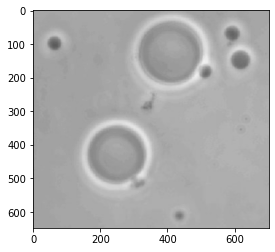

In [95]:
image = cv2.cvtColor(cv2.imread("../images/cell.tif"), cv2.COLOR_BGR2GRAY)

plt.imshow(image, cmap = 'gray', vmin = 0, vmax = 255)

<h2> Basic Global Thresholding </h2>

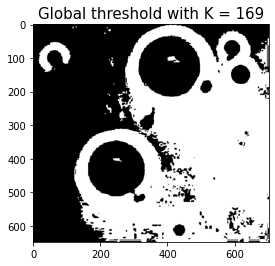

In [104]:
global_res,Tnew,_ = global_threshold(image)

plt.title(f"Global threshold with K = {Tnew}", fontsize = 15)
plt.imshow(global_res, cmap = 'gray', vmin = 0, vmax = 255)

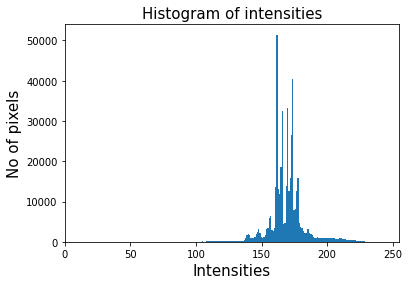

In [111]:
plt.title('Histogram of intensities', fontsize = 15)
plt.xlabel("Intensities", fontsize = 15)
plt.ylabel("No of pixels", fontsize = 15)
plt.xlim(0, 255)
plt.hist(image.reshape(-1), bins = 256, range = (0, 255))
plt.show()

<p>Basic global thresholding didn't perform well in this case. The algorithm found small valley between 150 and 180, which was not optimal in this case. </p>

<h2> Using Otsu's Technique </h2>

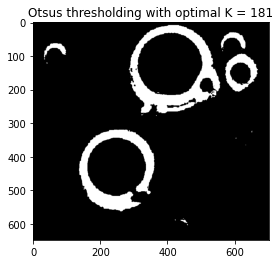

In [112]:
k_star, cache = otsu_threshold(image)


resImg = []

for pixel in image.reshape(-1) :
    
    if pixel > k_star:
        resImg.append(255)
        continue
        
    resImg.append(0)
    
resImg = np.array(resImg).reshape(image.shape)

plt.title(f"Otsus thresholding with optimal K = {k_star}")
plt.imshow(resImg, cmap = 'gray', vmin = 0, vmax = 255)

<h2> Plotting sigma_B</h2>

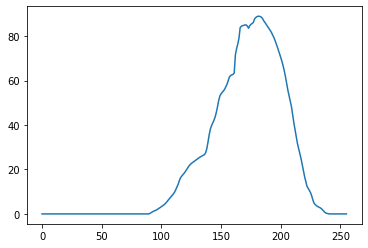

In [116]:
plt.plot(range(0, 256), cache['sigma_b'])

<h2> References </h2>

[1] Gonzalez, R. C., & Woods, R. E. (2002). Digital image processing.<br>
[2] Bradski, G. (2000). The OpenCV Library. Dr. Dobb&#x27;s Journal of Software Tools.<br>
[3] Otsu, N. (1979). A threshold selection method from gray-level histograms. IEEE transactions on systems, man, and cybernetics, 9(1), 62-66.<br>
